In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO


In [2]:
# ✅ Load YOLOv8 keypoint detection model
model = YOLO("yolov8n-pose.pt")  # Load the pre-trained YOLOv8 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)


YOLO(
  (model): PoseModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=

In [3]:
# ✅ Define the keypoints indices for the left side
YOLO_KEYPOINTS = {
    "LEFT_SHOULDER": 5,
    "LEFT_ELBOW": 7,
    "LEFT_WRIST": 9,
    "LEFT_HIP": 11,
    "LEFT_KNEE": 13,
    "LEFT_ANKLE": 15,
}


In [14]:
def load_image(image_path):
    """Loads an image and converts it to RGB format."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

# ✅ Provide your image path
image_path = r"C:\PJT2\Orbbec_Dataset_New\Orbbec_Dataset\Dataset\checkdataset\9.png" # Change this to your image path
image = load_image(image_path)


In [15]:
def predict_keypoints(model, image):
    """Runs YOLOv8 keypoint model and extracts keypoints."""
    results = model(image)  # Run inference

    if len(results) == 0 or results[0].keypoints is None:
        print("⚠️ No keypoints detected.")
        return None, None

    keypoints = results[0].keypoints.xy.cpu().numpy()  # Extract (x, y) keypoints
    confidence = results[0].keypoints.conf.cpu().numpy()  # Extract confidence scores

    return keypoints[0], confidence[0]  # Assuming single-person detection

# ✅ Predict keypoints
keypoints, confidence = predict_keypoints(model, image)



0: 384x640 1 person, 139.0ms
Speed: 4.7ms preprocess, 139.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


In [16]:
 def process_keypoints(image, keypoints, confidence):
    """Extracts selected keypoints, normalizes them, and draws on image."""
    height, width, _ = image.shape
    selected_keypoints = {}

    if keypoints is None or len(keypoints) == 0:
        print("⚠️ No keypoints detected.")
        return image, None

    for name, index in YOLO_KEYPOINTS.items():
        if index >= len(keypoints):
            print(f"⚠️ Missing keypoint: {name}")
            continue

        x, y = keypoints[index]
        conf = confidence[index]
        x_norm, y_norm = x / width, y / height  # Normalize coordinates
        
        selected_keypoints[name] = (x_norm, y_norm, conf)

        # Draw keypoints on image
        cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)
        cv2.putText(image, name, (int(x) + 5, int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return image, selected_keypoints

# ✅ Process keypoints if detected
if keypoints is not None and len(keypoints) > 0:
    image_with_keypoints, selected_keypoints = process_keypoints(image, keypoints, confidence)
else:
    print("⚠️ No valid keypoints detected.")
    selected_keypoints = None


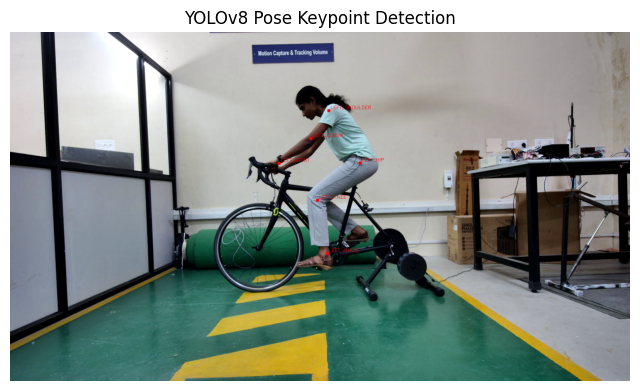

In [17]:
# ✅ Display the image with keypoints
plt.figure(figsize=(8, 8))
plt.imshow(image_with_keypoints)
plt.axis("off")
plt.title("YOLOv8 Pose Keypoint Detection")
plt.show()


In [18]:
# ✅ Print the normalized keypoints
if selected_keypoints:
    print("\nNormalized Keypoints (0-1 range) with Confidence Scores:")
    for name, (x_norm, y_norm, conf) in selected_keypoints.items():
        print(f"{name}: (x={x_norm:.5f}, y={y_norm:.5f}, confidence={conf:.2f})")
else:
    print("⚠️ No keypoints to display.")



Normalized Keypoints (0-1 range) with Confidence Scores:
LEFT_SHOULDER: (x=0.51450, y=0.22565, confidence=1.00)
LEFT_ELBOW: (x=0.48511, y=0.30467, confidence=1.00)
LEFT_WRIST: (x=0.43414, y=0.37663, confidence=0.99)
LEFT_HIP: (x=0.56461, y=0.37522, confidence=1.00)
LEFT_KNEE: (x=0.49624, y=0.48212, confidence=1.00)
LEFT_ANKLE: (x=0.51194, y=0.63446, confidence=0.98)
